# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Loading the data

In [0]:
DATA_DIR = './cell_images'
CATEGORIES = ['Parasitized', 'Uninfected']
data = []
IMG_SIZE = 50
for category in CATEGORIES:
    path = os.path.join(DATA_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_arr = cv2.imread(os.path.join(path,img))
            new_arr = cv2.resize(img_arr, (IMG_SIZE,IMG_SIZE))
            data.append([new_arr, class_num])
        except Exception as E:
            pass

In [5]:
np.shape(data)

(27558, 2)

# Separating features and labels

In [0]:
X = []
Y = []
for features, labels in data:
    X.append(features)
    Y.append(labels)
X = np.array(X)
X = X / 255


In [7]:
X.shape

(27558, 50, 50, 3)

# Plotting some images

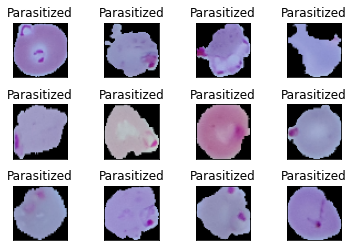

In [8]:
inde = np.random.randint(0 , 6543 , 12)
r = 0
for index in inde:
    r += 1
    plt.subplot(3,4,r)
    #grid  = X[index].reshape(IMG_SIZE,IMG_SIZE)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(X[index])
    plt.xticks([]) , plt.yticks([])
    plt.title(CATEGORIES[Y[index]])
plt.show()

In [9]:
np.unique(Y, return_counts=True)

(array([0, 1]), array([13779, 13779]))

In [0]:
#one hot encoding of labels
Y = to_categorical(Y)

# Spliting data into train, test, validation

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

# CNN

In [12]:
model = Sequential()
model.add(Conv2D(64,3,data_format='channels_last',padding='same',activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D(pool_size=(3,3)))
model.add(Conv2D(32, 3, data_format='channels_last',activation='relu', padding='same'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 32)          128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

# Data augumentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

# Model fitting

In [14]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=32), epochs=50, validation_data= (x_val,y_val))

Epoch 1/50
698/698 [==============================] - 20s 28ms/step - loss: 0.6983 - accuracy: 0.6231 - val_loss: 0.6907 - val_accuracy: 0.5449
Epoch 2/50
698/698 [==============================] - 18s 26ms/step - loss: 0.5582 - accuracy: 0.7284 - val_loss: 0.6044 - val_accuracy: 0.7682
Epoch 3/50
698/698 [==============================] - 18s 25ms/step - loss: 0.4668 - accuracy: 0.7985 - val_loss: 0.3492 - val_accuracy: 0.9069
Epoch 4/50
698/698 [==============================] - 18s 26ms/step - loss: 0.4436 - accuracy: 0.8099 - val_loss: 1.4237 - val_accuracy: 0.4933
Epoch 5/50
698/698 [==============================] - 18s 26ms/step - loss: 0.4052 - accuracy: 0.8385 - val_loss: 3.3121 - val_accuracy: 0.4925
Epoch 6/50
698/698 [==============================] - 18s 26ms/step - loss: 0.3811 - accuracy: 0.8567 - val_loss: 1.5611 - val_accuracy: 0.6247
Epoch 7/50
698/698 [==============================] - 18s 26ms/step - loss: 0.3725 - accuracy: 0.8535 - val_loss: 0.4400 - val_accuracy:

# Predicting

In [0]:
y_pred = model.predict(x_test)

# accuracy metrics

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred.round(), y_test)

0.9379535558780842

# training vs validation loss

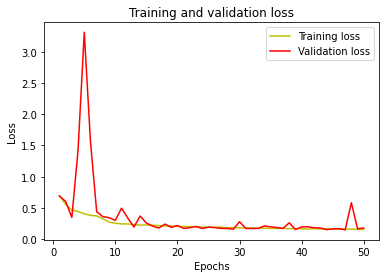

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

training vs validation accuracy

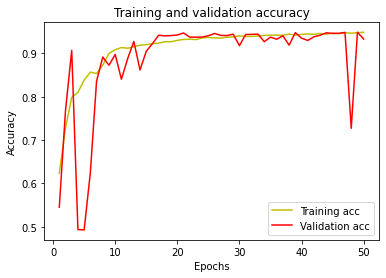

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()